In [4]:
import sys
import os
sys.path.insert(0, '/hpf/projects/ndlamini/scratch/wgao/python3.8.0/')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
import numpy as np
import cv2


import matplotlib.pyplot as plt
import nibabel as nib
import scipy
import albumentations as A
from skimage import morphology
from nibabel import processing
import nilearn.image

model = keras.models.load_model('t1_brain_extraction.keras', compile=False)

In [5]:
IMG_SIZE = 128
NUM_SLICES = 20

def predict_without_ground_truth(path_to_img):
    # load the image
    nifti = nib.load(path_to_img)
    nifti_resampled = processing.conform(nifti)

    num_slices = nifti_resampled.shape[2]
    X = np.empty((num_slices, IMG_SIZE, IMG_SIZE, 1))
    nifti_voxels = nifti_resampled.get_fdata()
    
    # resize input data to conform to model expectations
    for i in range(num_slices):
        X[i,:,:,0] = cv2.resize(nifti_voxels[:,:,i], (IMG_SIZE,IMG_SIZE))

    # normalize
    max_voxel = np.max(X)

    # predict
    prediction = model.predict(X/max_voxel, verbose=1)
    
    # convert to axial
    prediction = np.moveaxis(prediction[:, :, :, 1], 0, 2)
    
    # apply a gaussian blur
    prediction = scipy.ndimage.gaussian_filter(prediction, sigma=(1, 3, 3), order=0)

    # resize predictions back to the size of resampled input nifti
    resized_prediction = np.zeros(nifti_resampled.shape)
    
    for slice in range(prediction.shape[2]):
        # round the predictions to get a binary mask
        resized_prediction[:, :, slice] = np.round(cv2.resize(prediction[:, :, slice], (nifti_resampled.shape[0], nifti_resampled.shape[1]))).astype(int)

        # post processing, fill in any holes in mask
        resized_prediction[:, :, slice] = scipy.ndimage.binary_fill_holes(resized_prediction[:, :, slice])
        
        # post processing, remove any stray artifacts
        resized_prediction[:,:, slice] = morphology.remove_small_objects(resized_prediction[:,:, slice].astype(bool), IMG_SIZE*IMG_SIZE*0.01).astype(int)

    for slice in range(resized_prediction.shape[0]):
        # post processing, fill in any holes in mask
        resized_prediction[slice, :, :] = scipy.ndimage.binary_fill_holes(resized_prediction[slice, :, :])
        
        # post processing, remove any stray artifacts
        resized_prediction[slice, :, :] = morphology.remove_small_objects(resized_prediction[slice, :, :].astype(bool), IMG_SIZE*IMG_SIZE*0.01).astype(int)
    
    for slice in range(resized_prediction.shape[1]):
        # post processing, fill in any holes in mask
        resized_prediction[:, slice, :] = scipy.ndimage.binary_fill_holes(resized_prediction[:, slice, :])
        
        # post processing, remove any stray artifacts
        resized_prediction[:, slice, :] = morphology.remove_small_objects(resized_prediction[:, slice, :].astype(bool), IMG_SIZE*IMG_SIZE*0.01).astype(int)

    # save predictions
    prediction_nifti = nib.Nifti1Image(resized_prediction, nifti_resampled.affine, dtype=np.uint16)
    prediction_nifti = nilearn.image.resample_img(prediction_nifti, nifti.affine, nifti.shape, "nearest")
    
    # plot only the slices where mask is non-zero
    mask_non_zero_slices = np.sort(np.unique(np.nonzero(resized_prediction)[2]))
    mask_min_slice = mask_non_zero_slices[0]
    mask_max_slice = mask_non_zero_slices[-1]
    
    # give emphasis on bottom third of slices
    bottom_slices = np.round(np.linspace(mask_min_slice, mask_min_slice + (mask_max_slice - mask_min_slice)/3, num=NUM_SLICES//2)).astype(int)
    top_slices = np.round(np.linspace(mask_min_slice + (mask_max_slice - mask_min_slice)/2, mask_max_slice, num=NUM_SLICES//2)).astype(int)
    choices = np.append(bottom_slices, top_slices)
    
    # init plot
    _, axarr = plt.subplots(NUM_SLICES,2, figsize = (7, 7 * NUM_SLICES // 2)) 
    axarr[0][0].title.set_text('Original Image')
    axarr[0][1].title.set_text('Predicted Mask')
    
    # for each image, add brain background
    for idx, choice in enumerate(choices):
        axarr[idx][0].imshow(A.resize(nifti_voxels[:, :, choice], 128, 128), cmap='gray', aspect='auto')
        axarr[idx][1].imshow(A.resize(nifti_voxels[:, :, choice], 128, 128), cmap='gray', aspect='auto')
        axarr[idx][1].imshow(A.resize(resized_prediction[:, :, choice].astype(float), 128, 128), cmap='OrRd', alpha=0.5, aspect='auto')
    
    plt.show()
    
    # save prediction
    save_dir = os.path.dirname(path_to_img)
    save_file_path = os.path.join(save_dir, f'{save_dir.split(os.sep)[-1]}_pred.nii.gz')
    
    nib.save(prediction_nifti, save_file_path)
    
    print(f"Saved prediction to {save_file_path}")


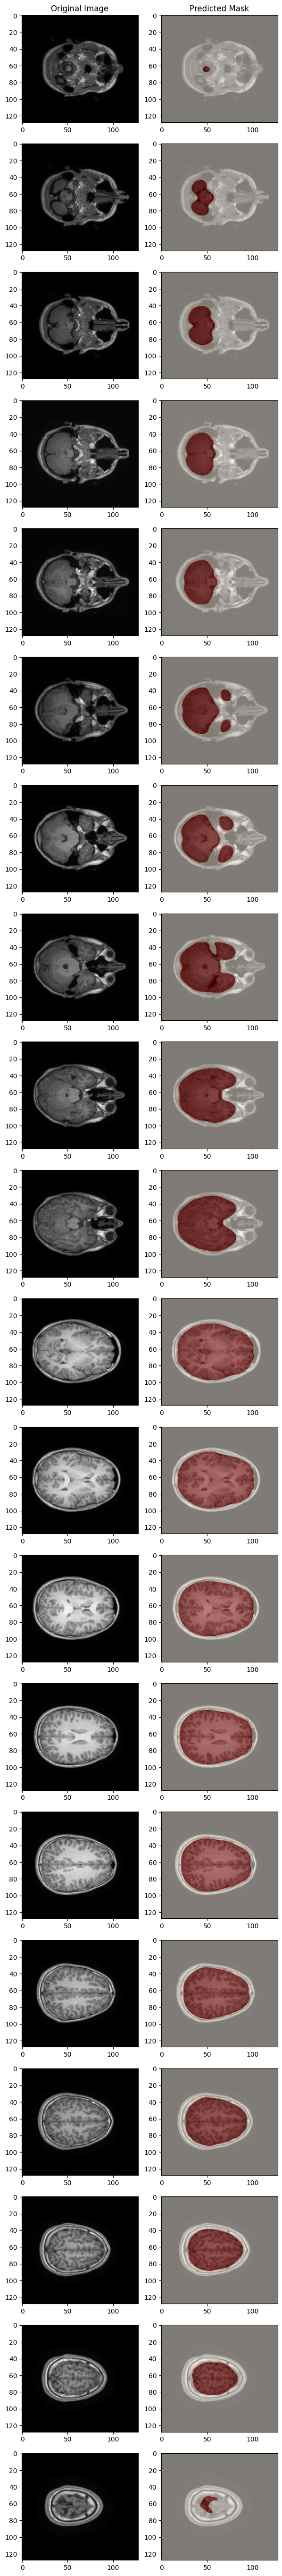

Saved prediction to /hpf/projects/ndlamini/scratch/wgao/demo/20723/20723_pred.nii.gz


In [6]:
predict_without_ground_truth('/hpf/projects/ndlamini/scratch/wgao/demo/20723/20723_T1.nii.gz')